In [354]:
include("../matrix_factorization.jl")
using Statistics, LinearAlgebra, Plots
using DelimitedFiles, Random

@profview matrix_factorization_experiment()

# Unlearing rule

Here the goal is to infer patterns from the coupling matrix $J$.
This problem is addressed to as "matrix factorization" since we have $J = \xi \xi^T$. <br>

In this first experiment we try the following algorithm:
- create a copy $J_{new}$ of $J$
- start from a random configuration $\sigma$;
- run two Monte Carlo simulation:
    - the first tries to minimize the energy of $\sigma$ using $J_{new}$ (the latter will be equal to $J$ at the first iteration);
    - take the output of the previous MC, let's say $\sigma_{new}$, and run a new MC using the original $J$;
- if the energy increases we stop the loop;
- otherwise we subtract the $\sigma_{new}$ configuration from $J_{new} -= \lambda \frac{\sigma_{new}^T \sigma }{N}$<br> 

The following is the chunk of code that we have just described (`recover_global_minimum` function)
```
...
 for t in 1:ntrials
    σnew = SH.monte_carlo(J_new, σ; nsweeps, earlystop = 0, β = 10, annealing)
    σnew = SH.monte_carlo(J, σnew; nsweeps, earlystop = 0, β = 10, annealing)
    Enew = SH.energy(J, σnew) / N

    if info
        @info "restart=$(r) trial=$(t)" E Enew SH.overlap(σ, σnew) Efinal
    end
    if Enew > E
        break
    end
    σ = σnew
    E = Enew
    J_new -= λ * σnew * σnew' ./ N
...
```
<br>

Check `matrix_factorization.jl` for details.

In [ ]:
N = [1000] # N should be bigger
α = [0.04]
nsamples = 2000

p = factorization_probability(α, N; show = false, save = false)
println("Probability to recover one global minimum for N=$N = ", p)

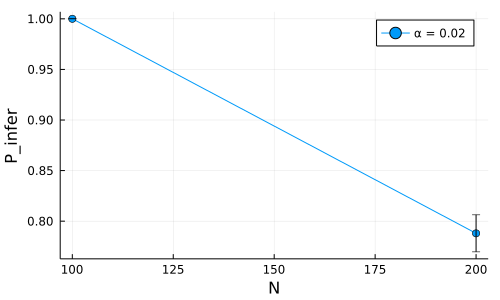

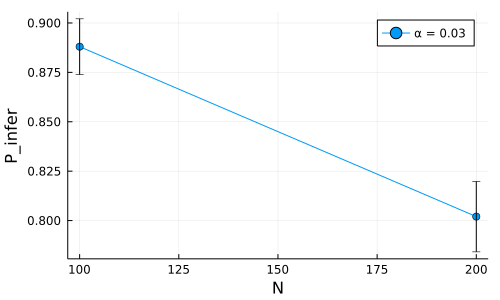

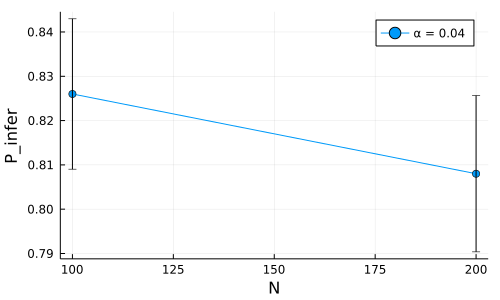

In [326]:
N = [1000] # N should be bigger
α = [0.04]
nsamples = 2000

p = factorization_probability(α, N; show = false, save = false, nrestarts = 10)
println("Probability to recover one global minimum for N=$N = ", p)

In [ ]:
N = [2000] # N should be bigger
α = [0.04]
nsamples = 2000

p = factorization_probability(α, N; show = false, save = false, nrestarts = 10)
println("Probability to recover one global minimum for N=$N = ", p)

In [3]:
α = 0.04
N = 1000
M = round(Int, N * α)
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

recover_global_minimum(J; ntrials = 10, info = true)

┌ Info: restart=1 trial=1
│   E = 0.0019400000000000034
│   Enew = -0.4554840000000004
│   SH.overlap(σ, σnew) = 0.078
│   Efinal = 0.006891999999999995
└ @ Main /Users/lorenzomancini/Desktop/Physics of Data/Thesis/codes/Standard Hopfield/Matrix Factorization/matrix_factorization.jl:73
┌ Info: restart=1 trial=2
│   E = -0.4554840000000004
│   Enew = -0.45719600000000005
│   SH.overlap(σ, σnew) = 0.384
│   Efinal = 0.006891999999999995
└ @ Main /Users/lorenzomancini/Desktop/Physics of Data/Thesis/codes/Standard Hopfield/Matrix Factorization/matrix_factorization.jl:73
┌ Info: restart=1 trial=3
│   E = -0.45719600000000005
│   Enew = -0.45612400000000003
│   SH.overlap(σ, σnew) = 0.216
│   Efinal = 0.006891999999999995
└ @ Main /Users/lorenzomancini/Desktop/Physics of Data/Thesis/codes/Standard Hopfield/Matrix Factorization/matrix_factorization.jl:73


([-1, -1, 1, 1, -1, -1, -1, 1, 1, 1  …  -1, 1, -1, -1, -1, -1, -1, -1, 1, -1], -0.45719600000000005)

# Stopping times

We expect that the number of sweeps needed for the recovery of a global minumum grows exponentially as the size $N$ increases.<br>
Now we would like to show in a simplified way this behaviour.
We proceed as follows:
- take a range of `nsweeps`e.g. `[10, 20, 30, 40, 50,...]`;
- for each element in the list, we compute the factorization probability (i.e. the fraction of times that we recover a global minimum, see above);
- if the probability is $\geq 0.98$ we stop.

In this way we find the minimum number (not the exact value but a rough estimate) of sweeps that we need to recover at least a global minimum for a given size.

In [3]:
τ50 = stopping_time(; N = 50)

10

In [4]:
τ100 = stopping_time(; N = 100)

60

In [6]:
τ150 = stopping_time(; N = 150)

150

In [7]:
τ200 = stopping_time(; N = 200)

530

In [8]:
N = [50, 100, 150, 200]
τ = [τ50, τ100, τ150, τ200]

4-element Vector{Int64}:
  10
  60
 150
 530

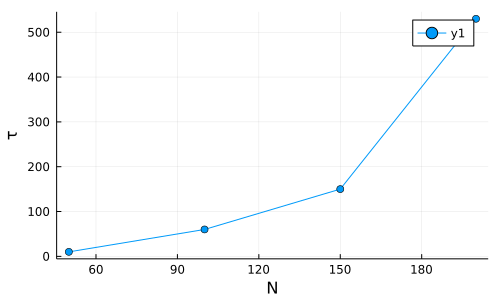

In [22]:
plot(N, τ, size = (500,300), markershape =:circle, xlabel = "N", ylabel = "τ")#, yscale=:log10)

## random stuff

M = 2
N = 10
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

ξ_new = zeros(Int64, (N,M))
ξ_new[1,:] = rand([-1,1], M)

J1 = N*J[:,1]


for i in 2:length(J1)
    q = round(Int64, (M + J1[i])/2)
    
    #q is the value of patterns such that the the spins 1 and i have the same values
    for j in 1:q
        ξ_new[i, j] = ξ_new[1, j]
    end
    for j in q+1:M
        ξ_new[i, j] = ξ_new[1, j]*(-1)
    end
    
end

Jb = SH.store(ξ_new)

J == Jb

ξ_new = zeros(Int64, (M,N))

ξ_new[1,:] = rand([-1,1], N)

ξ_new

M = 2
N = 3
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

J_new = SH.store(ξ_new)

# Minimize distance between matrices

Here we try a different approach. We start from a random $\xi$ of M patterns of size N and we try to minimize
$$
|| J - \xi \xi^T ||
$$
throug a zero-temperature MC.

In [355]:
Random.seed!(13)

N = 100
α = 0.1
M = round(Int, N*α)
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)
@time ξ_rec, dist = matrix_monte_carlo(J, M; nsweeps = 70)

  5.384133 seconds (239.80 k allocations: 2.538 GiB, 15.00% gc time, 1.50% compilation time)


([1 1 … -1 1; 1 1 … 1 1; … ; 1 -1 … 1 1; 1 -1 … -1 1], [4.488563244513772, 3.453925303187664, 2.692210987274214, 2.3315231073270537, 1.9764614845728716, 1.4243595051811884, 0.9516301802696255, 0.6216108107168021, 0.3959797974644666, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

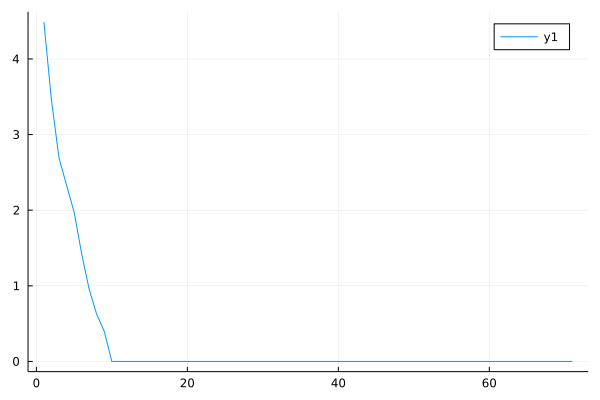

In [356]:
plot(dist)

In [357]:
α = 0.04
M = round(Int, N*α)
N = 200
ξ = SH.generate_patterns(M, N)
J = SH.store(ξ)

@time ξ_rec, dist = matrix_monte_carlo(J, M; nsweeps = 70)

 13.430895 seconds (83.22 k allocations: 5.913 GiB, 13.90% gc time)


([1 1 1 -1; -1 -1 1 -1; … ; -1 1 1 1; -1 1 -1 -1], [2.7985710639538888, 2.2287216066615407, 1.9379886480575679, 1.5704776343520463, 1.376880532217665, 1.257934815481311, 1.2244182292011174, 1.1992497654784011, 1.1992497654784011, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [358]:
findfirst(x -> x ==0, dist)

10